# 1. 回归

- 往往为多输入，单输出

# 2. 分类

- 通常为多输出
- 输出i为预测为第i类的概率

## 2.1 分类问题的标签

- 一位有效编码（one-hot）：每一种类别对应一位，正确类别对应位为1，其余位为0

## 2.2 分类问题的输出

- 比如预测n个类别，每个类别的置信度为$c_i$，则需要将这n个类别的置信度经过一个softmax函数，使类别与类别之间的取值更具差异化，使大的更大，小的更小

## 2.3 分类问题的损失函数

- 常用交叉熵损失函数
  
  ![image-20230315095953261](https://zyc-learning-1309954661.cos.ap-nanjing.myqcloud.com/machine-learning-pic/image-20230315095953261.png)


# 3. 分类问题的数据集

Fashion-MNIST数据集

In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

- 将图像数据从PIL图像类型数据转为tensor类型
  ```py
    # 定义一系列转换操作
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
  ```

In [6]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)


- mnist_train是一个数据集对象，可以像列表一样使用，如：
  - 取第一个样本：`mnist_train[0]`
  - 取第一个样本的feature：`mnist_train[0][0]`
  - 取第一个样本的label：`mnist_train[0][1]`
- 每个样本的feature是一个28*28的图像

In [23]:
type(mnist_train[0][0]), mnist_train[0][0].shape

(torch.Tensor, torch.Size([1, 28, 28]))

## [实验1]：使用不同进程数，比较读取相同数据集的速度

在使用`DataLoader`制作数据集时，可以制定参数`num_workers`设置读取数据的进程数。

<BarContainer object of 8 artists>

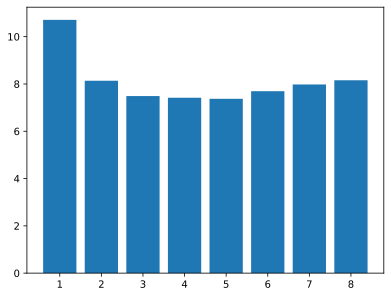

In [27]:
import matplotlib.pyplot as plt

batch_size = 256
time_spent = []
num_process = []

for i in range(8):
    train_iter = iter(data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=i+1))
    timer = d2l.Timer()
    for x,y in train_iter:
        ...
    time_spent.append(timer.stop())
    num_process.append(i+1)

plt.bar(num_process, time_spent)

## [实验2]：编写一个完整的读取数据集函数

In [5]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

def load_data_fashion_minist(batch_size, resize = None):
    # 预处理
    trans = [
        transforms.ToTensor()
    ]
    if resize:
        trans.insert(transforms.Resize(resize))
    trans = transforms.Compose(trans)

    # 读取数据集
    mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)

    # 制作成dataloader
    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
    test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=4)

    return train_iter, test_iter

# 测试
batch_size = 256
train_iter, test_iter = load_data_fashion_minist(batch_size)
print(next(iter(train_iter))[0].shape)
print(next(iter(train_iter))[1].shape)

torch.Size([256, 1, 28, 28])
torch.Size([256])


# 4. softmax回归的简单实现

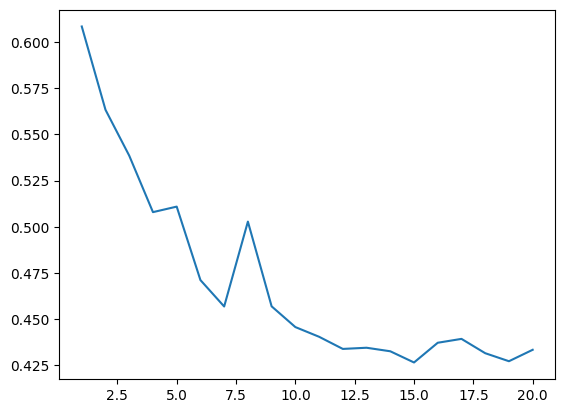

In [11]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 获取数据集
batch_size = 256
train_dataLoader, test_dataLoader = load_data_fashion_minist(batch_size)

# 定义网络
net = nn.Sequential(
    nn.Flatten(),               # 256*28*28 展开成 256*784(多用在全连接层之前)
    nn.Linear(784, 10)
).to(device)

# 初始化各个层的参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

# 定义损失函数
loss = nn.CrossEntropyLoss()

# 训练策略
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# 开始训练
losses = []
epoch_num = []
epochs = 20
for epoch in range(epochs):
    train_iter = iter(train_dataLoader)
    test_iter = iter(test_dataLoader)

    # 更新参数
    for x, y in train_iter:
        x,y = x.to(device), y.to(device)
        l = loss(net(x), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()

    # 计算测试集损失
    test_loss = 0
    for features, labels in test_iter:
        features, labels = features.to(device), labels.to(device)
        test_loss += loss(net(features), labels)
    test_loss /= len(test_dataLoader)

    # 添加数据
    losses.append(test_loss.item())
    epoch_num.append(epoch+1)

plt.plot(epoch_num, losses)

- 在 PyTorch 中，net.apply(func) 方法的作用是将函数 func 应用到神经网络 net 中的每一层。具体步骤如下：
  - 遍历 net 中的每个模块（每一层）。
  - 对每个模块调用函数 func，并将当前模块作为参数传递给 func。
- 在 init_weights 函数中，参数 m 是由 PyTorch 自动传递的当前层（模块）对象。
- `nn.init.normal_(tensor, mean=0.0, std=1.0)`

# 5. 编写一个求多分类问题的准确率函数

In [ ]:
def 